# Wildfire Spread Predictions with 3D U-Net

This notebook demonstrates how to:
1. Load a trained 3D U-Net model
2. Load a sample from the dataset
3. Make predictions
4. Visualize the results

In [51]:
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add src to path
sys.path.append('../../src')
from models.unet3d import UNet3D
from preprocessing.feature_engineering_pytorch import WildfireDatasetWithFeatures

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'}")

Imports successful!
PyTorch version: 2.9.0
Device available: mps


## 1. Load the Trained Model

In [52]:
# Configuration
MODEL_PATH = Path('../../prod_models/UNET3D/3D-UNET-WILDFIRE-1.pt')
DATA_DIR = Path('../../data/raw/dataset_64_64_all_10days_final/2022/Spain')
STATS_PATH = Path('../../data/processed/normalization_stats.json')
SAMPLE_FILE = 'corrected_sample_10238.nc'  # You can change this to any sample

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [53]:
# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)

print("Checkpoint Info:")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Metrics: {checkpoint['metrics']}")
print()

# Create model with same architecture
# The model was trained with 30 channels (includes fire_history and ignition_points)
model = UNet3D(
    in_channels=30,  # Model with fire_history features
    out_channels=1,
    base_channels=32,
    depth=3
).to(device)

# Load weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Checkpoint Info:
  Epoch: 47
  Metrics: {'loss': 0.3485436737537384, 'accuracy': 0.9999938905239105, 'precision': 0.9972677528858185, 'recall': 0.9972677528858185, 'f1': 0.9972677230834961, 'iou': 0.9945652186870575}

Model loaded successfully!
Model parameters: 5,627,585


## 2. Load a Sample from the Dataset

In [54]:
# Load sample file path
sample_path = DATA_DIR / SAMPLE_FILE
print(f"Loading sample: {sample_path}")

# Create dataset with normalization
# The model expects 30 channels (with fire_history and ignition_points)
dataset = WildfireDatasetWithFeatures(
    file_paths=[sample_path],
    apply_feature_engineering=True,
    normalize=True,
    augment=False,
    stats_path=STATS_PATH
)

# Load sample
features, target, metadata = dataset[0]

print(f"\nSample Info:")
print(f"  Sample ID: {metadata['sample_id']}")
print(f"  Country: {metadata['country']}")
print(f"  Date: {metadata['date']}")
print(f"  Burned area (ha): {metadata['burned_area_ha']}")
print(f"\nData shapes:")
print(f"  Features: {features.shape}  (T, C, H, W)")
print(f"  Target: {target.shape}  (T, H, W)")

Loading sample: ../../data/raw/dataset_64_64_all_10days_final/2022/Spain/corrected_sample_10238.nc
Loaded normalization statistics from ../../data/processed/normalization_stats.json
  Number of channels: 30

Sample Info:
  Sample ID: corrected_sample_10238
  Country: Spain
  Date: 2022-07-16
  Burned area (ha): 56961.0

Data shapes:
  Features: torch.Size([10, 30, 64, 64])  (T, C, H, W)
  Target: torch.Size([10, 64, 64])  (T, H, W)


## 3. Make Predictions

In [55]:
# Prepare input for model
# Dataset returns [T, C, H, W], model expects [B, C, T, H, W]
features_input = features.unsqueeze(0)  # Add batch dimension: [1, T, C, H, W]
features_input = features_input.permute(0, 2, 1, 3, 4)  # Permute to [1, C, T, H, W]
features_input = features_input.to(device)

print(f"Input shape to model: {features_input.shape}")

# Make prediction
with torch.no_grad():
    prediction = model(features_input)  # Output: [1, 1, T, H, W]
    prediction_prob = torch.sigmoid(prediction)  # Convert to probabilities

print(f"Prediction shape: {prediction.shape}")
print(f"Prediction range: [{prediction_prob.min().item():.4f}, {prediction_prob.max().item():.4f}]")

# Convert to numpy for visualization
prediction_prob = prediction_prob.cpu().squeeze().numpy()  # [T, H, W]
target_np = target.numpy()  # [T, H, W]

print(f"\nPrediction array shape: {prediction_prob.shape}")

Input shape to model: torch.Size([1, 30, 10, 64, 64])
Prediction shape: torch.Size([1, 1, 10, 64, 64])
Prediction range: [0.0000, 1.0000]

Prediction array shape: (10, 64, 64)


# Prepare input for model
# Dataset returns [T, C, H, W], model expects [B, C, T, H, W]
features_input = features.unsqueeze(0)  # Add batch dimension: [1, T, C, H, W]
features_input = features_input.permute(0, 2, 1, 3, 4)  # Permute to [1, C, T, H, W]
features_input = features_input.to(device)

print(f"Input shape to model: {features_input.shape}")

# Make prediction
with torch.no_grad():
    prediction = model(features_input)  # Output: [1, 1, T, H, W]
    prediction_prob = torch.sigmoid(prediction)  # Convert to probabilities

print(f"Prediction shape: {prediction.shape}")
print(f"Prediction range: [{prediction_prob.min().item():.4f}, {prediction_prob.max().item():.4f}]")

# Convert to numpy for visualization
prediction_prob = prediction_prob.cpu().squeeze().numpy()  # [T, H, W]
target_np = target.numpy()  # [T, H, W]

print(f"\nPrediction array shape: {prediction_prob.shape}")

Saved visualization to: prediction_visualization.png


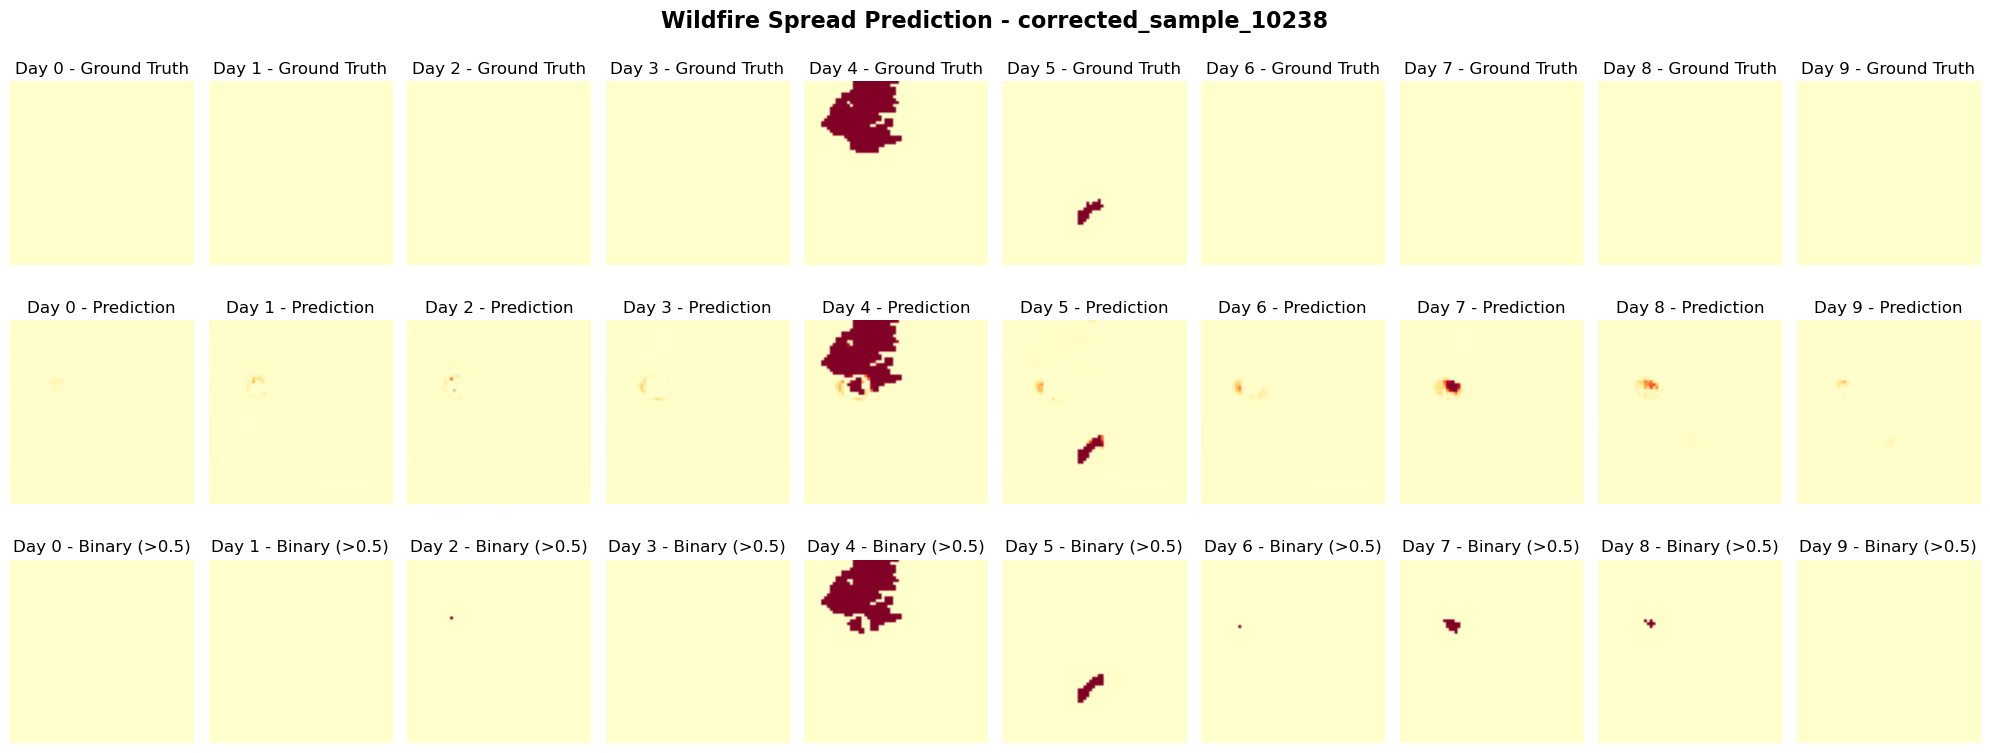

In [56]:
# Visualize predictions for each timestep
num_timesteps = prediction_prob.shape[0]

fig, axes = plt.subplots(3, num_timesteps, figsize=(20, 8))
fig.suptitle(f'Wildfire Spread Prediction - {metadata["sample_id"]}', fontsize=16, fontweight='bold')

for t in range(num_timesteps):
    # Ground truth
    axes[0, t].imshow(target_np[t], cmap='YlOrRd', vmin=0, vmax=1)
    axes[0, t].set_title(f'Day {t} - Ground Truth')
    axes[0, t].axis('off')
    
    # Prediction (probability)
    axes[1, t].imshow(prediction_prob[t], cmap='YlOrRd', vmin=0, vmax=1)
    axes[1, t].set_title(f'Day {t} - Prediction')
    axes[1, t].axis('off')
    
    # Binary prediction (threshold at 0.5)
    pred_binary = (prediction_prob[t] > 0.5).astype(float)
    axes[2, t].imshow(pred_binary, cmap='YlOrRd', vmin=0, vmax=1)
    axes[2, t].set_title(f'Day {t} - Binary (>0.5)')
    axes[2, t].axis('off')

plt.tight_layout()
plt.savefig('prediction_visualization.png', dpi=150, bbox_inches='tight')
print("Saved visualization to: prediction_visualization.png")
plt.show()

## 5. Compute Metrics

In [57]:
# Compute metrics for each timestep
threshold = 0.5

print(f"\nMetrics (threshold={threshold}):")
print("=" * 80)
print(f"{'Day':<5} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'IoU':<10}")
print("=" * 80)

for t in range(num_timesteps):
    pred_binary = (prediction_prob[t] > threshold).astype(float)
    target_t = target_np[t]
    
    # Flatten
    pred_flat = pred_binary.flatten()
    target_flat = target_t.flatten()
    
    # Compute metrics
    tp = ((pred_flat == 1) & (target_flat == 1)).sum()
    fp = ((pred_flat == 1) & (target_flat == 0)).sum()
    tn = ((pred_flat == 0) & (target_flat == 0)).sum()
    fn = ((pred_flat == 0) & (target_flat == 1)).sum()
    
    epsilon = 1e-7
    accuracy = (tp + tn) / (tp + fp + tn + fn + epsilon)
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    iou = tp / (tp + fp + fn + epsilon)
    
    print(f"{t:<5} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {iou:<10.4f}")

print("=" * 80)


Metrics (threshold=0.5):
Day   Accuracy   Precision  Recall     F1         IoU       
0     1.0000     0.0000     0.0000     0.0000     0.0000    
1     1.0000     0.0000     0.0000     0.0000     0.0000    
2     0.9998     0.0000     0.0000     0.0000     0.0000    
3     1.0000     0.0000     0.0000     0.0000     0.0000    
4     0.9937     0.9886     0.9539     0.9710     0.9436    
5     0.9976     0.8205     0.9143     0.8649     0.7619    
6     0.9998     0.0000     0.0000     0.0000     0.0000    
7     0.9956     0.0000     0.0000     0.0000     0.0000    
8     0.9985     0.0000     0.0000     0.0000     0.0000    
9     1.0000     0.0000     0.0000     0.0000     0.0000    


## 6. Compare Fire Spread Animation

Saved comparison to: comparison_first_5_days.png


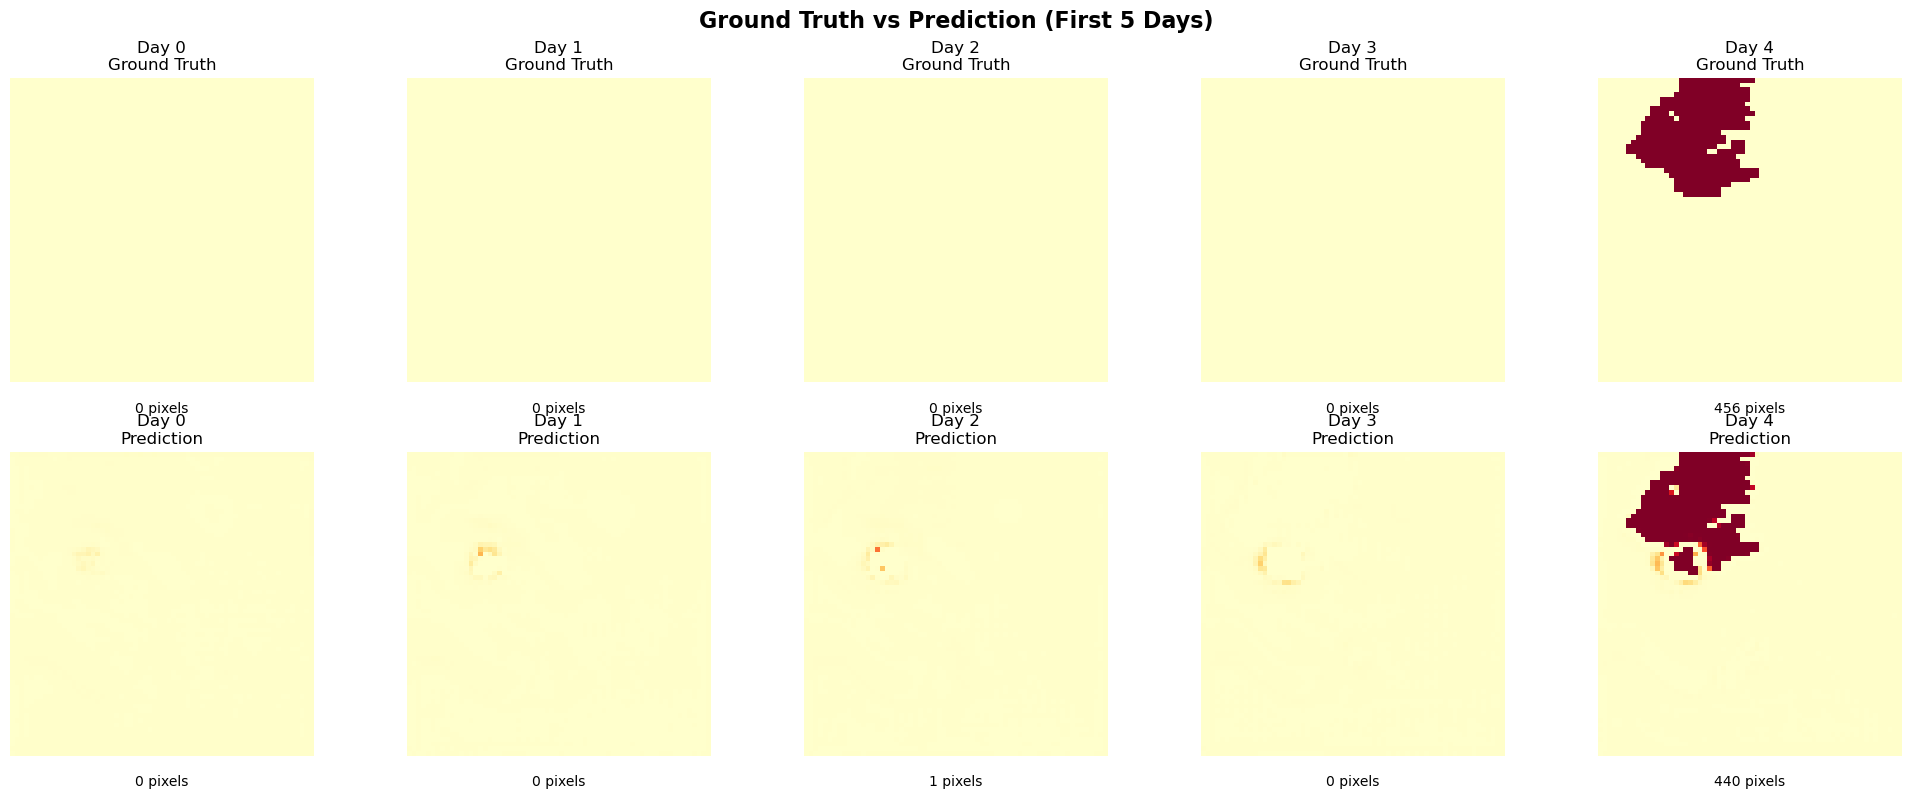

In [58]:
# Create side-by-side comparison
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Ground Truth vs Prediction (First 5 Days)', fontsize=16, fontweight='bold')

for t in range(min(5, num_timesteps)):
    # Ground truth
    axes[0, t].imshow(target_np[t], cmap='YlOrRd', vmin=0, vmax=1, interpolation='nearest')
    axes[0, t].set_title(f'Day {t}\nGround Truth', fontsize=12)
    axes[0, t].axis('off')
    
    # Count burned pixels
    burned_actual = target_np[t].sum()
    axes[0, t].text(0.5, -0.1, f'{int(burned_actual)} pixels', 
                    transform=axes[0, t].transAxes, ha='center', fontsize=10)
    
    # Prediction
    axes[1, t].imshow(prediction_prob[t], cmap='YlOrRd', vmin=0, vmax=1, interpolation='nearest')
    axes[1, t].set_title(f'Day {t}\nPrediction', fontsize=12)
    axes[1, t].axis('off')
    
    # Count predicted pixels
    burned_pred = (prediction_prob[t] > threshold).sum()
    axes[1, t].text(0.5, -0.1, f'{int(burned_pred)} pixels', 
                    transform=axes[1, t].transAxes, ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('comparison_first_5_days.png', dpi=150, bbox_inches='tight')
print("Saved comparison to: comparison_first_5_days.png")
plt.show()

## 7. GIFs

In [59]:
# Define feature names and select key features to display
# Showing all 30 features would be too crowded, so we'll show the most important ones
feature_names_all = [
    'DEM', 'Slope', 'Aspect', 'Curvature', 'Roads Distance',
    'Population', 'LC Forest', 'LC Shrubland', 'LC Grassland',
    'LC Agriculture', 'LC Settlement', 'Temperature', 'Dewpoint',
    'Humidity', 'Wind Speed', 'Wind Direction', 'Precipitation',
    'Pressure', 'Solar Rad', 'NDVI', 'LAI', 'Soil Moisture',
    'LST Day', 'LST Night', 'Wind U', 'Wind V', 'TRI', 'VPD',
    'Fire History', 'Ignition'
]

# Select key features to display (indices)
# key_features = [
#     0,   # DEM
#     1,   # Slope
#     11,  # Temperature
#     13,  # Humidity
#     14,  # Wind Speed
#     16,  # Precipitation
#     19,  # NDVI
#     21,  # Soil Moisture
#     28,  # Fire History
#     29,  # Ignition Points
# ]

key_features = list(range(0, len(feature_names_all)))

print(f"Selected {len(key_features)} key features to display:")
for idx in key_features:
    print(f"  Channel {idx}: {feature_names_all[idx]}")

Selected 30 key features to display:
  Channel 0: DEM
  Channel 1: Slope
  Channel 2: Aspect
  Channel 3: Curvature
  Channel 4: Roads Distance
  Channel 5: Population
  Channel 6: LC Forest
  Channel 7: LC Shrubland
  Channel 8: LC Grassland
  Channel 9: LC Agriculture
  Channel 10: LC Settlement
  Channel 11: Temperature
  Channel 12: Dewpoint
  Channel 13: Humidity
  Channel 14: Wind Speed
  Channel 15: Wind Direction
  Channel 16: Precipitation
  Channel 17: Pressure
  Channel 18: Solar Rad
  Channel 19: NDVI
  Channel 20: LAI
  Channel 21: Soil Moisture
  Channel 22: LST Day
  Channel 23: LST Night
  Channel 24: Wind U
  Channel 25: Wind V
  Channel 26: TRI
  Channel 27: VPD
  Channel 28: Fire History
  Channel 29: Ignition


In [60]:
# Install imageio if needed for GIF creation
try:
    import imageio
    print("imageio already installed")
except ImportError:
    print("Installing imageio...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'imageio'])
    import imageio
    print("imageio installed successfully")

from IPython.display import Image as IPImage

# Create output directory for GIFs
gif_dir = Path('prediction_gifs')
gif_dir.mkdir(exist_ok=True)
print(f"GIF will be saved to: {gif_dir}")

imageio already installed
GIF will be saved to: prediction_gifs


In [61]:
# Create comprehensive GIF with all key features and predictions
print("Creating comprehensive GIF with all variables and predictions...")
print("=" * 80)

frames = []
features_np = features.numpy()  # [T, C, H, W]

for t in range(num_timesteps):
    # Create figure with 4 rows x 3 columns
    # Row 1-3: Key input features (10 features)
    # Row 4: Ground truth, Prediction, Binary prediction
    fig = plt.figure(figsize=(36, 48))
    gs = fig.add_gridspec(10, 3, hspace=1, wspace=1)

    fig.suptitle(f'Wildfire Prediction - Day {t} - {metadata["sample_id"]}',
                 fontsize=20, fontweight='bold', y=0.995)

    # Plot key input features
    for i, feature_idx in enumerate(key_features):
        row = i // 3
        col = i % 3
        ax = fig.add_subplot(gs[row, col])

        feature_data = features_np[t, feature_idx, :, :]
        feature_name = feature_names_all[feature_idx]

        # Choose colormap
        if 'Fire' in feature_name or 'Ignition' in feature_name:
            cmap = 'YlOrRd'
        elif 'Temperature' in feature_name or 'LST' in feature_name:
            cmap = 'RdYlBu_r'
        elif 'NDVI' in feature_name or 'LAI' in feature_name:
            cmap = 'Greens'
        elif 'Moisture' in feature_name or 'Humidity' in feature_name or 'Precipitation' in feature_name:
            cmap = 'Blues'
        elif 'DEM' in feature_name or 'Slope' in feature_name:
            cmap = 'terrain'
        else:
            cmap = 'viridis'

        im = ax.imshow(feature_data, cmap=cmap, interpolation='nearest')
        ax.set_title(feature_name, fontsize=12, fontweight='bold')
        ax.axis('off')

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)

    # Row 4: Ground truth, Prediction, Binary prediction
    # Ground Truth
    ax1 = fig.add_subplot(gs[3, 0])
    im1 = ax1.imshow(target_np[t], cmap='YlOrRd', vmin=0, vmax=1, interpolation='nearest')
    ax1.set_title('Ground Truth', fontsize=14, fontweight='bold')
    ax1.axis('off')
    burned_actual = int(target_np[t].sum())
    ax1.text(0.5, -0.08, f'{burned_actual} pixels burned',
            transform=ax1.transAxes, ha='center', fontsize=11, fontweight='bold')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # Prediction Probability
    ax2 = fig.add_subplot(gs[3, 1])
    im2 = ax2.imshow(prediction_prob[t], cmap='YlOrRd', vmin=0, vmax=1, interpolation='nearest')
    ax2.set_title('Prediction (Probability)', fontsize=14, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Binary Prediction
    ax3 = fig.add_subplot(gs[3, 2])
    pred_binary = (prediction_prob[t] > threshold).astype(float)
    im3 = ax3.imshow(pred_binary, cmap='YlOrRd', vmin=0, vmax=1, interpolation='nearest')
    ax3.set_title(f'Prediction (threshold={threshold})', fontsize=14, fontweight='bold')
    ax3.axis('off')
    burned_pred = int(pred_binary.sum())
    ax3.text(0.5, -0.08, f'{burned_pred} pixels burned',
            transform=ax3.transAxes, ha='center', fontsize=11, fontweight='bold')
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

    # Save frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frames.append(frame[:, :, :3])

    plt.close(fig)
    print(f"  Created frame {t+1}/{num_timesteps}")

# Save comprehensive GIF
comprehensive_gif_path = gif_dir / f'comprehensive_wildfire_prediction_{SAMPLE_FILE}.gif'
imageio.mimsave(comprehensive_gif_path, frames, duration=1000, loop=0)

print("=" * 80)
print(f"✓ Comprehensive GIF created: {comprehensive_gif_path}")
print(f"  File size: {comprehensive_gif_path.stat().st_size / 1024:.1f} KB")
print(f"  Frames: {len(frames)}")
print(f"  Duration per frame: 1000ms (1 second)")

Creating comprehensive GIF with all variables and predictions...
  Created frame 1/10
  Created frame 2/10
  Created frame 3/10
  Created frame 4/10
  Created frame 5/10
  Created frame 6/10
  Created frame 7/10
  Created frame 8/10
  Created frame 9/10
  Created frame 10/10
✓ Comprehensive GIF created: prediction_gifs/comprehensive_wildfire_prediction_corrected_sample_10238.nc.gif
  File size: 3235.3 KB
  Frames: 10
  Duration per frame: 1000ms (1 second)


## 8. Statistics

In [62]:
# Overall statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

# Total burned area
total_burned_actual = (target_np > 0).sum()
total_burned_pred = (prediction_prob > threshold).sum()

print(f"\nBurned Pixels:")
print(f"  Ground Truth: {total_burned_actual:,}")
print(f"  Predicted:    {total_burned_pred:,}")
print(f"  Difference:   {int(total_burned_pred - total_burned_actual):,} ({((total_burned_pred - total_burned_actual) / total_burned_actual * 100):.1f}%)")

# Prediction confidence
print(f"\nPrediction Confidence:")
print(f"  Mean probability: {prediction_prob.mean():.4f}")
print(f"  Max probability:  {prediction_prob.max():.4f}")
print(f"  Min probability:  {prediction_prob.min():.4f}")

# Fire progression
print(f"\nFire Progression (Ground Truth):")
for t in range(num_timesteps):
    burned = (target_np[t] > 0).sum()
    print(f"  Day {t}: {burned:4d} pixels burned")

print(f"\nFire Progression (Predicted):")
for t in range(num_timesteps):
    burned = (prediction_prob[t] > threshold).sum()
    print(f"  Day {t}: {burned:4d} pixels burned")

print("=" * 80)


SUMMARY STATISTICS

Burned Pixels:
  Ground Truth: 491
  Predicted:    505
  Difference:   14 (2.9%)

Prediction Confidence:
  Mean probability: 0.0178
  Max probability:  1.0000
  Min probability:  0.0000

Fire Progression (Ground Truth):
  Day 0:    0 pixels burned
  Day 1:    0 pixels burned
  Day 2:    0 pixels burned
  Day 3:    0 pixels burned
  Day 4:  456 pixels burned
  Day 5:   35 pixels burned
  Day 6:    0 pixels burned
  Day 7:    0 pixels burned
  Day 8:    0 pixels burned
  Day 9:    0 pixels burned

Fire Progression (Predicted):
  Day 0:    0 pixels burned
  Day 1:    0 pixels burned
  Day 2:    1 pixels burned
  Day 3:    0 pixels burned
  Day 4:  440 pixels burned
  Day 5:   39 pixels burned
  Day 6:    1 pixels burned
  Day 7:   18 pixels burned
  Day 8:    6 pixels burned
  Day 9:    0 pixels burned
